# Introduction

In this notebook, we will implement the standard method of Collaborative Filtering with the Pareto Dominance. It is inspired by this paper: 
http://www.sciencedirect.com/science/article/pii/S0020025513002004

In [1]:
# Import the fucking useful libraries =)
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from helpers_CF_and_PD import *
import scipy.stats as sp
import scipy.spatial.distance as spsd
from operator import itemgetter

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

In [2]:
# Define here the data set
dataset = '../../data/data_train.csv'

# Load the data and prepare them


In [3]:
data = prepare_data(dataset)
# Prepare the data
U, I, R, I_u = variables(data)

Load the dataset
Prepare the variables


Get the sets of non-dominated users. (Already calculated)

In [4]:
# Folder for the preprocessing file
folder = "./"

non_dom_users_file = folder + "non-dominated-users.pickle"

# Get the file
C = get_pickle(non_dom_users_file)

# Make some tests

In order to make sure that the preprocessing is correct, we need to plot some graph

In [5]:
# We define an array of values equals to number of candidates over number of items rated
c_over_ir = []
nbr_cand = []
nbr_itms = []
for usr in U:
    c_over_ir.append(len(C[usr])/len(I_u[usr]))
    nbr_cand.append(len(C[usr]))
    nbr_itms.append(len(I_u[usr]))
len(c_over_ir)

10000

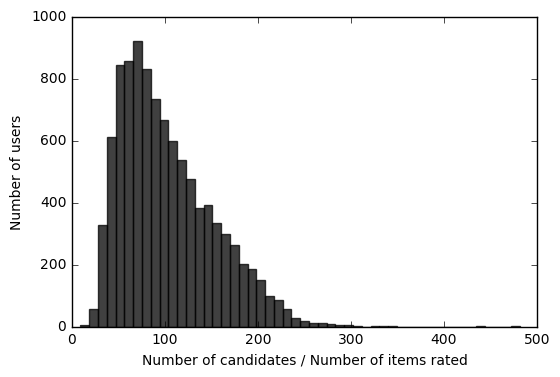

In [6]:
n, bins, patches = plt.hist(c_over_ir, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of candidates / Number of items rated')
plt.ylabel('Number of users')

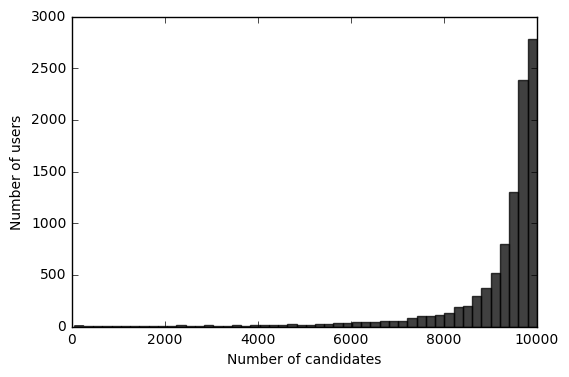

In [7]:
n, bins, patches = plt.hist(nbr_cand, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of candidates')
plt.ylabel('Number of users')

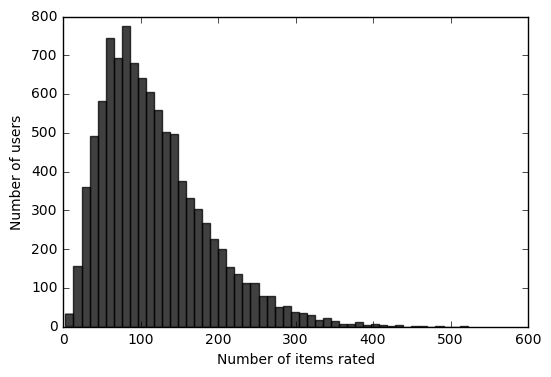

In [8]:
n, bins, patches = plt.hist(nbr_itms, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of items rated')
plt.ylabel('Number of users')

In [9]:
nbr_itms.index(min(nbr_itms))

480

In [10]:
len(C[480])

148

In [11]:
nbr_cand.index(min(nbr_cand))

3677

In [12]:
nbr_itms[3677]

6

Difficult to say if it worked or not.. But it seems ok... =)

# K-NN

Now, we will prepare for the kNN

In [13]:
def pearson_vector(R, u, I_u, subset):
    # items rated by u
    items_u = I_u[u]
    
    corr_vec = []
    
    for x in subset:
        A_ux = list(set(items_u).intersection(I_u[x]))
        corr = np.abs(sp.pearsonr(R[u,A_ux], R[x,A_ux])[0])
        if corr != corr:
            corr_vec.append(0.0)
        else:
            corr_vec.append(corr)
            
    return corr_vec        

In [14]:
def cosine_vector(R, u, I_u, subset):
    # items rated by u
    items_u = I_u[u]
    
    cosine_vec = []
    
    for x in subset:
        A_ux = list(set(items_u).intersection(I_u[x]))
        if len(R[u,A_ux]) == 0:
            cosine_vec.append(-np.inf)
        else:
            cosine_vec.append(spsd.cosine(R[u,A_ux], R[x,A_ux]))
            
    return cosine_vec 

In [15]:
def msd_vector(R, u, I_u, subset):
    # items rated by u
    items_u = I_u[u]
    
    msd_vec = []
    
    for x in subset:
        A_ux = list(set(items_u).intersection(I_u[x]))
        msd_vec.append(msd(R[u,A_ux], R[x,A_ux]))
            
    return msd_vec 

def msd(x, y):
    # WARNING: We hardcode the max and min value here
    max_ = 5
    min_ = 1
    if len(x) == 0:
        return -np.inf
    else:
        return 1-(1/len(x))*np.sum(((x-y)/(max_-min_))**2)

In [16]:
def nearest_neighbors(folder, R, u, U, I_u, method, subset=None):
    # Get the similarity vectors
    usrs = []
    if subset == None:
        usrs = U
    else:
        usrs = subset[u]
    
    if method == 'pearson':
        vec = pearson_vector(R, usr, I_u, usrs)
    elif method == 'cosine':
        vec = cosine_vector(R, usr, I_u, usrs)  
    elif method == 'msd':
        vec = msd_vector(R, usr, I_u, usrs)

    # Sort the vector
    sorted_vec = sorted(enumerate(vec), key=itemgetter(1), reverse=True)
    
    NN_u = [usrs[i[0]] for i in sorted_vec]
        
    filename = folder + "NN_" + str(u) + "_" + method + ".pickle"
    pickle.dump(NN_u, open(filename, "wb"))
    #print("  NN_%i created"%(u))
    

In [17]:
def all_nearest_neighbors(folder, method, U):   
    NN = []
    for usr in U:
        filename = folder + "NN_" + str(usr) + "_" + method + ".pickle"
        NN.append(pickle.load(open(filename, "rb")))
        
    file_name = folder + "NN_" + method + ".pickle" 

    pickle.dump(NN, open(file_name, "wb"))

    return file_name

In [18]:
%%time
folder = "./pickles/"
method = "pearson"

for u in U:
    nearest_neighbors(folder, R, u, U, I_u, method, subset=C)
    if (u+1)%500 == 0:
        print("%i/%i done!"%(u+1, len(U)))
file_pearson = all_nearest_neighbors(folder, method, U)

/home/gael/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


500/10000 done!
1000/10000 done!
1500/10000 done!
2000/10000 done!
2500/10000 done!
3000/10000 done!
3500/10000 done!
4000/10000 done!
4500/10000 done!
5000/10000 done!
5500/10000 done!
6000/10000 done!
6500/10000 done!
7000/10000 done!
7500/10000 done!
8000/10000 done!
8500/10000 done!
9000/10000 done!
9500/10000 done!
10000/10000 done!
CPU times: user 1h 52min 1s, sys: 4.39 s, total: 1h 52min 5s
Wall time: 1h 52min 1s


In [19]:
%%time
folder = "./pickles/"
method = "cosine"

for u in U:
    nearest_neighbors(folder, R, u, U, I_u, method, subset=C)
    if (u+1)%500 == 0:
        print("%i/%i done!"%(u+1, len(U)))
file_cosine = all_nearest_neighbors(folder, method, U)

500/10000 done!
1000/10000 done!
1500/10000 done!
2000/10000 done!
2500/10000 done!
3000/10000 done!
3500/10000 done!
4000/10000 done!
4500/10000 done!
5000/10000 done!
5500/10000 done!
6000/10000 done!
6500/10000 done!
7000/10000 done!
7500/10000 done!
8000/10000 done!
8500/10000 done!
9000/10000 done!
9500/10000 done!
10000/10000 done!
CPU times: user 1h 39min 11s, sys: 4.01 s, total: 1h 39min 15s
Wall time: 1h 39min 12s


In [18]:
%%time
folder = "./pickles/"
method = "msd"

for u in U:
    nearest_neighbors(folder, R, u, U, I_u, method, subset=C)
    if (u+1)%500 == 0:
        print("%i/%i done!"%(u+1, len(U)))
file_msd = all_nearest_neighbors(folder, method, U)

500/10000 done!
1000/10000 done!
1500/10000 done!
2000/10000 done!
2500/10000 done!
3000/10000 done!
3500/10000 done!
4000/10000 done!
4500/10000 done!
5000/10000 done!
5500/10000 done!
6000/10000 done!
6500/10000 done!
7000/10000 done!
7500/10000 done!
8000/10000 done!
8500/10000 done!
9000/10000 done!
9500/10000 done!
10000/10000 done!
CPU times: user 1h 4min 15s, sys: 3.22 s, total: 1h 4min 18s
Wall time: 1h 4min 17s
